#### Import packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import lightgbm as lgb
import xgboost as xgb

import operator
import pickle
import matplotlib.pyplot as plt

/home/arsh/anaconda3/envs/deepLearn/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Read Data 

In [2]:
# Read in our input data
train = pd.read_csv('../Dataset/train/train.csv')
test = pd.read_csv('../Dataset/test/test.csv')


# This prints out (rows, columns) in each dataframe
print('Train shape:', train.shape)
print('Test shape:', test.shape)


id_train = train['id'].values
y = train.target.values
id_test = test['id'].values

Train shape: (595212, 59)
Test shape: (892816, 58)


In [3]:
# Define the gini metric - from https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703#5897
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

# Create an XGBoost-compatible metric from Gini

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score

def gini_lgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', 1-gini_score, False

In [4]:
# We drop these variables as we don't want to train on them
# The other 57 columns are all numerical and can be trained on without preprocessing

train['countNAs'] = train.isin(['-1']).sum(axis=1)
test['countNAs'] = test.isin(['-1']).sum(axis=1)

train = train.drop(['id','target'], axis=1)
test = test.drop(['id'], axis=1)

# train_cont = train.drop(['id','ps_ind_02_cat','ps_ind_04_cat','ps_ind_05_cat','ps_car_01_cat',
#                     'ps_car_02_cat','ps_car_03_cat','ps_car_04_cat','ps_car_05_cat',
#                     'ps_car_06_cat','ps_car_07_cat','ps_car_08_cat','ps_car_09_cat',
#                     'ps_car_10_cat','ps_car_11_cat','target'], axis=1)
# test_cont = test.drop(['id','ps_ind_02_cat','ps_ind_04_cat','ps_ind_05_cat','ps_car_01_cat',
#                     'ps_car_02_cat','ps_car_03_cat','ps_car_04_cat','ps_car_05_cat',
#                     'ps_car_06_cat','ps_car_07_cat','ps_car_08_cat','ps_car_09_cat',
#                     'ps_car_10_cat','ps_car_11_cat'], axis=1)

# # One-hot encoding
# one_hot = OneHotEncoder()
# train_cat = train[['ps_ind_02_cat','ps_ind_04_cat','ps_ind_05_cat','ps_car_01_cat',
#                     'ps_car_02_cat','ps_car_03_cat','ps_car_04_cat','ps_car_05_cat',
#                     'ps_car_06_cat','ps_car_07_cat','ps_car_08_cat','ps_car_09_cat',
#                     'ps_car_10_cat','ps_car_11_cat']]
# test_cat = test[['ps_ind_02_cat','ps_ind_04_cat','ps_ind_05_cat','ps_car_01_cat',
#                     'ps_car_02_cat','ps_car_03_cat','ps_car_04_cat','ps_car_05_cat',
#                     'ps_car_06_cat','ps_car_07_cat','ps_car_08_cat','ps_car_09_cat',
#                     'ps_car_10_cat','ps_car_11_cat']]

# train_cat = train_cat.replace(-1, 999)
# test_cat = test_cat.replace(-1, 999)

# train_cat = one_hot.fit_transform(train_cat).toarray()
# test_cat = one_hot.fit_transform(test_cat).toarray()

# X = np.concatenate((train_cat, train_cont.values), axis=1)
# test = np.concatenate((test_cat, test_cont.values), axis=1)
# # standardise = StandardScaler()
# # standardise = standardise.fit(X)
# # X = standardise.transform(X)
# # test = standardise.transform(test)
# # # print('Train shape:', train.shape)
# # # print('Test shape:', test.shape)

In [13]:
# import pickle
# pickle.dump([X,y], open('one_hot_and_original_X_y.pickle', 'wb'))

In [5]:
X = train.values
test = test.values

In [6]:
# Log(x+2) Transformation
X_log = np.log(np.add(X,2))
test_log = np.log(np.add(test,2))

X = np.concatenate((X, X_log), axis=1)
test = np.concatenate((test, test_log), axis=1)

In [6]:
top_features = pickle.load(open('top_features.pickle', 'rb'))
top_features= top_features[np.where(top_features>=184)]

# PCA for top feature combinations
X_more = X[:, top_features]
test_more = test[:, top_features]
pca = PCA(n_components=10)
X_more = pca.fit_transform(X_more)
test_more = pca.fit_transform(test_more)

IndexError: index 230 is out of bounds for axis 1 with size 228

In [7]:
# Keeping only top features
top_features = pickle.load(open('top_features.pickle', 'rb'))
top_features = np.concatenate((top_features[np.where(top_features<184)], np.arange(184,242)), axis=0)
X_top = X[:, top_features]
test_top = test[:, top_features]

In [8]:
# PCA for other features
X = X[:, -top_features]
test = test[:, -top_features]
pca = PCA(n_components=15)
X = pca.fit_transform(X)
test = pca.fit_transform(test)

In [14]:
# Adding PCA features
X = np.concatenate((X_top, X_more, X), axis=1)
test = np.concatenate((test_top, test_more, test), axis=1)

In [6]:
X, X_val, y, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [7]:
indices = np.where(y==1)[0]

In [8]:
X = np.concatenate((X, np.repeat(X[indices], 27, axis=0)), axis=0)
y = np.concatenate((y, np.repeat(y[indices], 27, axis=0)), axis=0)

##### XGBoost 

In [11]:
# X = train.values
x_test = test
#x_test = get_features([test.values])[0]
xgbscores = []

# Set xgb parameters
params = {}
params['objective'] = 'binary:logistic'
# params['booster'] = 'dart'
params['eta'] = 0.02
params['silent'] = True
# params['eval_metric'] = 'ndcg@20000'
params['max_depth'] = 6
params['subsample'] = 0.9
params['colsample_bytree'] = 0.9
params['colsample_bylevel'] = 0.9
params['seed'] = 99
# params['rate_drop'] = 0.1
# params['skip_drop'] = 0.1
# params['sample_type'] = 'weighted'
# params['normalize_type'] = 'forest'
# params['one_drop'] = 1
# params['gamma'] = 15
# params['lambda'] = 10
# params['alpha'] = 1
# params['scale_pos_weight'] = 26.43671061122891
# params['tree-method'] = 'gpu_exact'
# params['grow-policy'] = 'lossguide'

In [13]:
import gc
gc.collect()

0

In [14]:
# Create a submission file
sub = pd.DataFrame()
sub['id'] = id_test
sub['target'] = np.zeros_like(id_test)

kfold = 5
weights = []
feature_imps = []
sss = KFold(n_splits=kfold, random_state=0)
for i, (train_index, test_index) in enumerate(sss.split(X, y)):
    
    print('[Fold %d/%d]' % (i + 1, kfold))
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    # Convert our data into LGBoost format
    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
#     d_valid_gini = xgb.DMatrix(X_valid)
#     d_valid_2 = xgb.DMatrix(X_val, y_val)
    d_test = xgb.DMatrix(x_test)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]

    # Train the model! We pass in a max of 2,000 rounds (with early stopping after 100)
    # and the custom metric (maximize=True tells xgb that higher metric is better)
    mdl = xgb.train(params, d_train, 5000, watchlist, early_stopping_rounds=170,feval=gini_xgb,
                    maximize=True, verbose_eval=100)

    print('[Fold %d/%d Prediction:]' % (i + 1, kfold))
    feature_imps.append(mdl.get_fscore())
    # Predict on our test data
    p_test = mdl.predict(d_test)
    print(mdl.best_score)
#     val_gini = mdl.predict(d_valid_gini)
#     print(gini_normalized(y_valid, val_gini))
#     print(gini_normalized(y_val, mdl.predict(d_valid_2)))
    weight = mdl.best_score
    weights.append(weight)
    sub['target'] += p_test*weight

sub['target'] = sub['target']/np.sum(weights)

[Fold 1/5]
[0]	train-gini:0.213068	valid-gini:0.201776
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 170 rounds.
[100]	train-gini:0.286089	valid-gini:0.255302
[200]	train-gini:0.328227	valid-gini:0.268097
[300]	train-gini:0.368506	valid-gini:0.276877
[400]	train-gini:0.40209	valid-gini:0.279295
[500]	train-gini:0.428046	valid-gini:0.280042
[600]	train-gini:0.451254	valid-gini:0.278921
Stopping. Best iteration:
[495]	train-gini:0.426912	valid-gini:0.280073

[Fold 1/5 Prediction:]


KeyboardInterrupt: 

In [60]:
# Create a submission file
sub.to_csv('./submit/v15_xgb_one_hot_standardized_gamma_15_depth_7_colbytree_07_10_fold_val_2869.csv.gz', 
           index=False, compression='gzip')

In [109]:
val_scores = [0.279973, 0.283588, 0.282138, 0.291781, 0.277837]
np.mean(val_scores)

0.28306339999999997

In [11]:
one_hot_standardized_lambda_100_val_scores = [0.282158, 0.282431, 0.286325, 0.294444, 0.275561]
np.mean(one_hot_standardized_lambda_100_val_scores)
one_hot_standardized_lambda_100_poisson_val_scores = [0.282493, 0.283971, 0.286585, 0.294414, 0.276483]
np.mean(one_hot_standardized_lambda_100_poisson_val_scores)
one_hot_and_original_standardized_gamma_17_depth_8_eta_015_val_scores = [0.282456, 0.280899, 0.284503,
                                                                 0.290474, 0.273345]
np.mean(one_hot_and_original_standardized_gamma_17_depth_8_eta_015_val_scores)
one_hot_standardized_gamma_15_depth_7_colbytree_07_10_fold_val_scores = [0.301454, 0.269646, 0.292486,
                                                                 0.27597, 0.294481, 0.27325, 0.301893,
                                                                        0.281695, 0.2969622, 0.281281]
np.mean(one_hot_standardized_gamma_15_depth_7_colbytree_07_10_fold_val_scores)

0.28691181999999993

#### Feature Importance Plots

In [133]:
feature_imps = [sorted(i.items(), key=operator.itemgetter(1), reverse=True) for i in feature_imps]

In [134]:
feature_imps = [pd.DataFrame(i) for i in feature_imps]

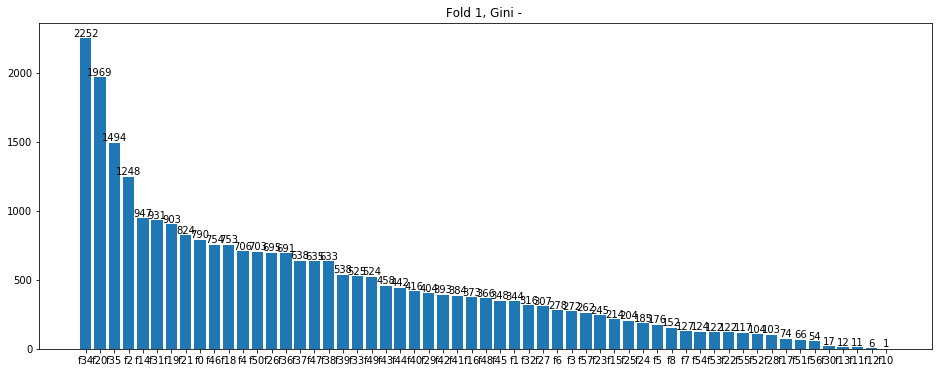

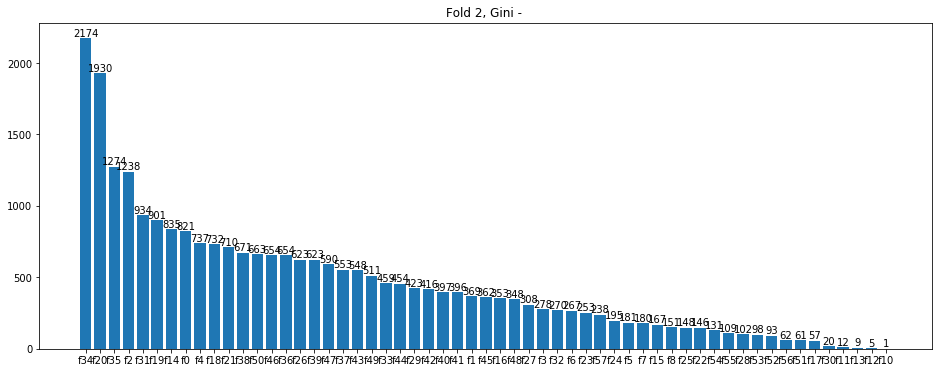

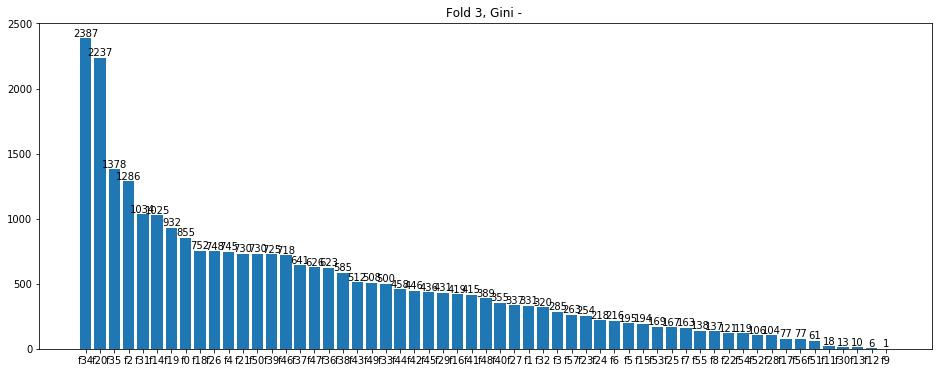

In [139]:
for idx, fold in enumerate(feature_imps):
    fold = fold.iloc[:65,:]
    plt.figure(figsize=(16,6))
    plt.bar(np.arange(len(fold)), fold[1], align='center')
    plt.xticks(np.arange(len(fold)), fold[0])
    plt.title('Fold '+str(idx+1)+', Gini - ' )
    
    # For value labels
    for idx, value in enumerate(fold[1]):
        plt.text(idx, value, 
             str(fold[1][idx]), ha='center', va='bottom')
    plt.show()

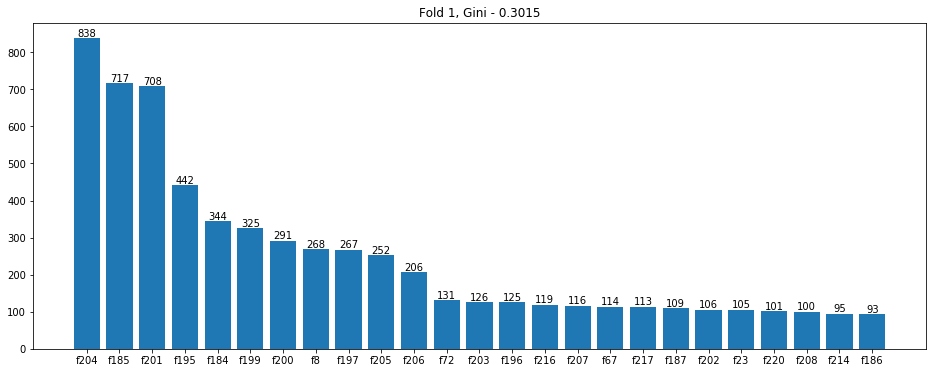

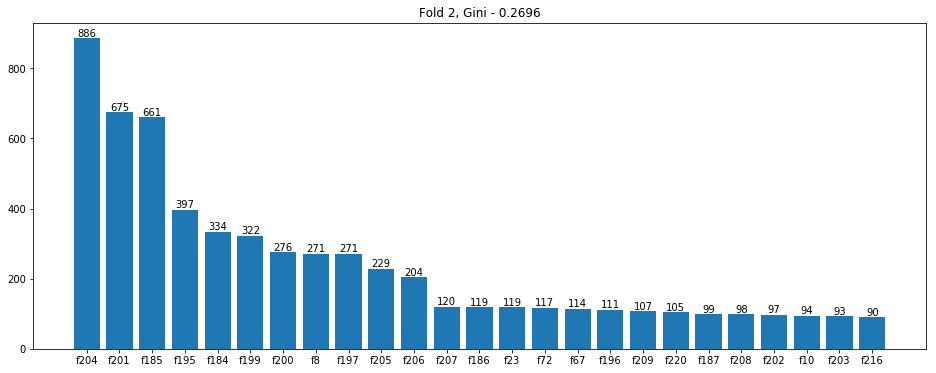

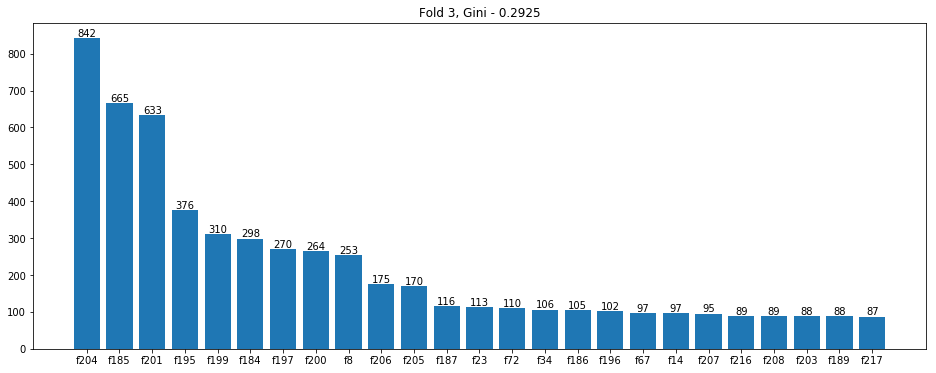

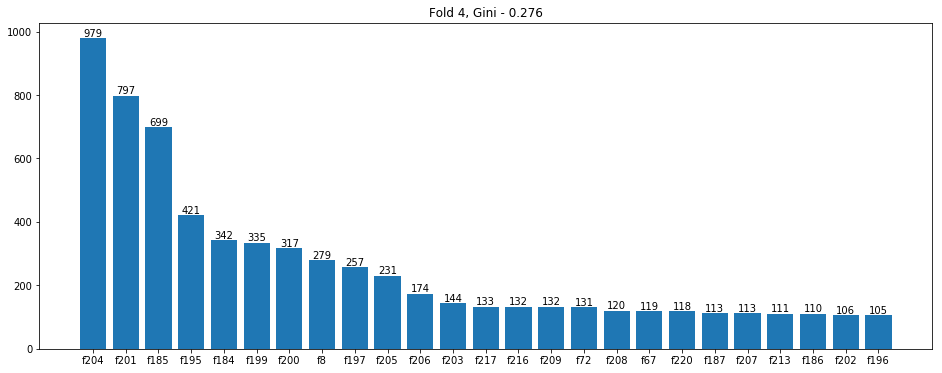

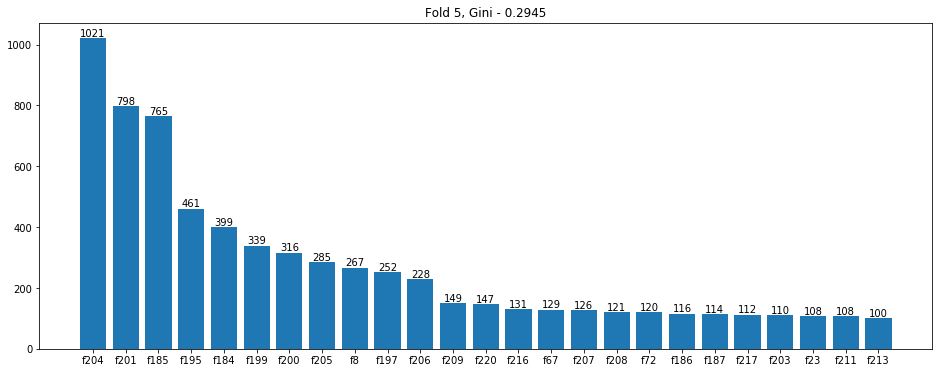

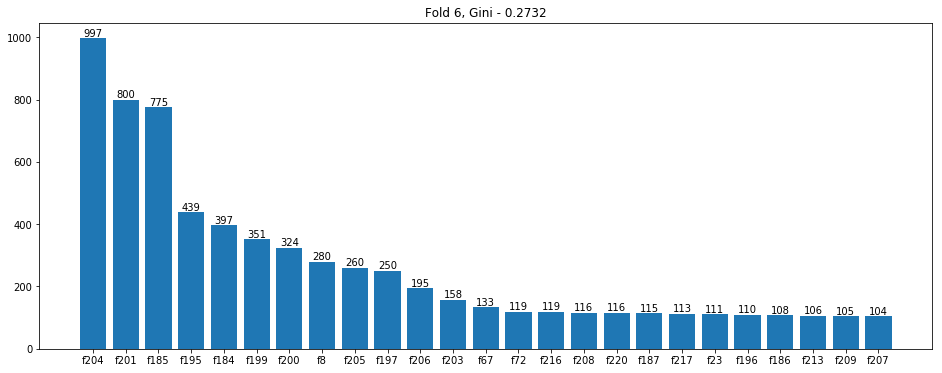

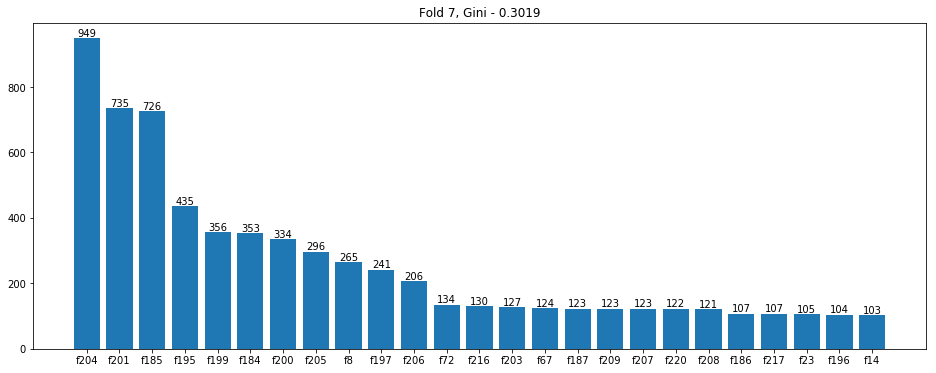

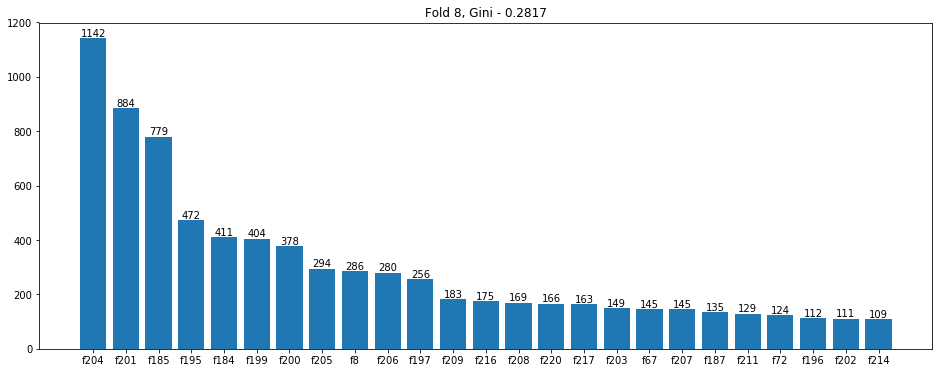

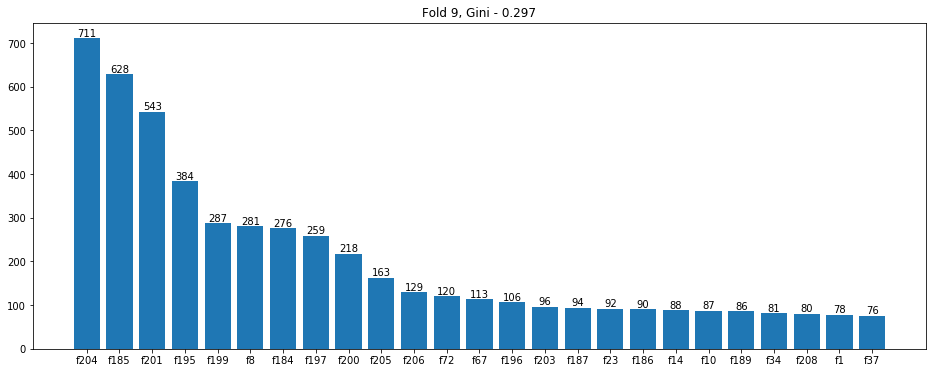

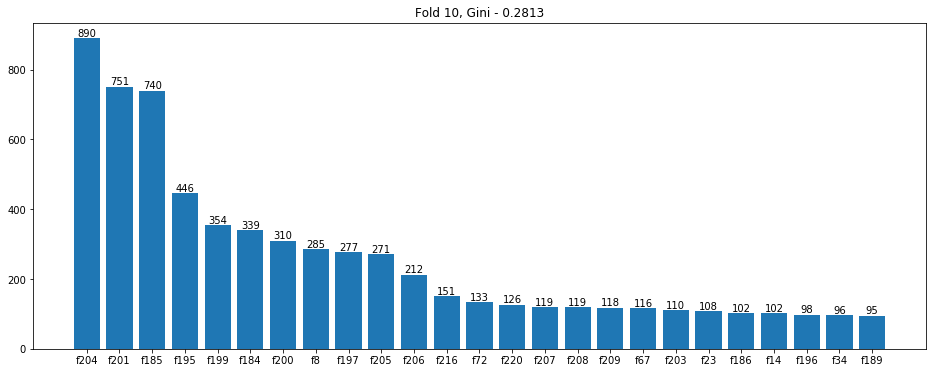

In [17]:
for idx, fold in enumerate(feature_imps):
    fold = fold.iloc[:25,:]
    plt.figure(figsize=(16,6))
    plt.bar(np.arange(len(fold)), fold[1], align='center')
    plt.xticks(np.arange(len(fold)), fold[0])
    plt.title('Fold '+str(idx+1)+', Gini - ' +str(round(
        one_hot_standardized_gamma_15_depth_7_colbytree_07_10_fold_val_scores[idx], 4)))
    
    # For value labels
    for idx, value in enumerate(fold[1]):
        plt.text(idx, value, 
             str(fold[1][idx]), ha='center', va='bottom')
    plt.show()

In [18]:
# Common top features
top_features = []
for fold in feature_imps:
    top_features+=list(fold.iloc[:25,0].values)
top_features = set(top_features)
top_features = np.array([int(i[1:]) for i in top_features])
top_features

array([217, 206, 195, 184, 205, 209, 208, 189,   1, 216, 186,  10, 202,
       213, 220, 197, 185,  23, 204, 201, 203, 187, 214,  67, 199,   8,
       196, 200,  37,  14,  72, 207,  34, 211])

In [19]:
import pickle
pickle.dump(top_features, open('top_features.pickle', 'wb'))

In [10]:
kfold=10
sss = StratifiedKFold(n_splits=kfold, random_state=0)
for i, (train_index, test_index) in enumerate(sss.split(X, y)):
    if i==1:
        X_train_hard_1, X_valid_hard_1 = X[train_index], X[test_index]
        y_train_hard_1, y_valid_hard_1 = y[train_index], y[test_index]
        # Convert our data into LGBoost format
        d_train_hard_1 = xgb.DMatrix(X_train_hard_1, y_train_hard_1)
        d_valid_hard_1 = xgb.DMatrix(X_valid_hard_1, y_valid_hard_1)
    if i==8:
        X_train_hard_2, X_valid_hard_2 = X[train_index], X[test_index]
        y_train_hard_2, y_valid_hard_2 = y[train_index], y[test_index]
        # Convert our data into LGBoost format
        d_train_hard_2 = xgb.DMatrix(X_train_hard_2, y_train_hard_2)
        d_valid_hard_2 = xgb.DMatrix(X_valid_hard_2, y_valid_hard_2)

In [11]:
pickle.dump([[X_train_hard_1, X_valid_hard_1, y_train_hard_1, y_valid_hard_1],
              [X_train_hard_2, X_valid_hard_2, y_train_hard_2, y_valid_hard_2]],
             open('hard_folds.pickle', 'wb'))

In [35]:
[X_train_hard_1, X_valid_hard_1, y_train_hard_1, y_valid_hard_1], [X_train_hard_2, X_valid_hard_2, y_train_hard_2, y_valid_hard_2] = pickle.load(open('hard_folds.pickle', 'rb'))

In [36]:
X_train_hard_1 = np.concatenate((X_train_hard_1, np.reshape(np.product(X_train_hard_1[:,np.array((201,204))], axis=1),
                                (len(X_train_hard_1),1))), axis=1)
X_train_hard_2 = np.concatenate((X_train_hard_2, np.reshape(np.product(X_train_hard_2[:,np.array((201,204))], axis=1),
                                (len(X_train_hard_2),1))), axis=1)
X_valid_hard_1 = np.concatenate((X_valid_hard_1, np.reshape(np.product(X_valid_hard_1[:,np.array((201,204))], axis=1),
                                (len(X_valid_hard_1),1))), axis=1)
X_valid_hard_2 = np.concatenate((X_valid_hard_2, np.reshape(np.product(X_valid_hard_2[:,np.array((201,204))], axis=1),
                                (len(X_valid_hard_2),1))), axis=1)

In [37]:
d_train_hard_1 = xgb.DMatrix(X_train_hard_1, y_train_hard_1)
d_valid_hard_1 = xgb.DMatrix(X_valid_hard_1, y_valid_hard_1)
# Convert our data into LGBoost format
d_train_hard_2 = xgb.DMatrix(X_train_hard_2, y_train_hard_2)
d_valid_hard_2 = xgb.DMatrix(X_valid_hard_2, y_valid_hard_2)

In [40]:
import gc
gc.collect()

0

In [41]:
# X = train.values
# x_test = test
#x_test = get_features([test.values])[0]
xgbscores = []

# Set xgb parameters
params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.02
params['silent'] = True
params['max_depth'] = 7
params['subsample'] = 0.7
params['colsample_bytree'] = 0.9
params['colsample_bylevel'] = 0.9
params['seed'] = 99
params['gamma'] = 15
# params['lambda'] = 50
# params['alpha'] = 1
# params['scale_pos_weight'] = 26.43671061122891
# params['tree-method'] = 'gpu_exact'
# params['grow-policy'] = 'lossguide'

In [42]:
watchlist = [(d_train_hard_1, 'train'), (d_valid_hard_1, 'valid')]

# Train the model! We pass in a max of 2,000 rounds (with early stopping after 100)
# and the custom metric (maximize=True tells xgb that higher metric is better)
mdl = xgb.train(params, d_train_hard_1, 5000, watchlist, early_stopping_rounds=170, feval=gini_xgb, 
                maximize=True, verbose_eval=100)

[0]	train-gini:0.162708	valid-gini:0.156593
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 170 rounds.
[100]	train-gini:0.246353	valid-gini:0.220205
[200]	train-gini:0.284509	valid-gini:0.243879
[300]	train-gini:0.304194	valid-gini:0.254601
[400]	train-gini:0.316651	valid-gini:0.26029
[500]	train-gini:0.324708	valid-gini:0.262228
[600]	train-gini:0.331138	valid-gini:0.262986
[700]	train-gini:0.336406	valid-gini:0.263375
[800]	train-gini:0.34142	valid-gini:0.263626
[900]	train-gini:0.346208	valid-gini:0.264556
[1000]	train-gini:0.350813	valid-gini:0.264978
[1100]	train-gini:0.354543	valid-gini:0.2651
[1200]	train-gini:0.359215	valid-gini:0.265948
[1300]	train-gini:0.362666	valid-gini:0.266106
[1400]	train-gini:0.365741	valid-gini:0.266618
[1500]	train-gini:0.36922	valid-gini:0.266709


KeyboardInterrupt: 

##### LightGBM

In [91]:
X = train.values
x_test = test.values
#x_test = get_features([test.values])[0]
lgbmscores = []

# Set LightGBM parameters
params = {
    'application': 'binary',
    'objective': 'binary',
    'is_unbalance': 'true',
    'boosting': 'gbdt',
    'num_leaves': 30,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.9,
    'bagging_freq': 20,
    'learning_rate': 0.05,
    'max_depth': 15,
    'verbose': 0,
    'seed': 99
#     'lambda_l2' : 10,
#     'lambda_l1' : 1
}
# params['objective'] = 'binary'
# params['num_leaves'] = 150
# params['learning_rate'] = 0.02
# params['max_depth'] = 5
# params['subsample'] = 0.9
# params['seed'] = 99
# params['lambda_l2'] = 10
# params['lambda_l1'] = 1

In [92]:
# Create a submission file
sub = pd.DataFrame()
sub['id'] = id_test
sub['target'] = np.zeros_like(id_test)

kfold = 5
sss = KFold(n_splits=kfold, random_state=0)
for i, (train_index, test_index) in enumerate(sss.split(X, y)):
    print('[Fold %d/%d]' % (i + 1, kfold))
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    # Convert our data into LGBoost format
    d_train = lgb.Dataset(X_train, y_train)
    d_valid = lgb.Dataset(X_valid, y_valid)
    watchlist = [d_train, d_valid]

    # Train the model! We pass in a max of 2,000 rounds (with early stopping after 100)
    # and the custom metric (maximize=True tells xgb that higher metric is better)
    mdl = lgb.train(params, train_set=d_train, num_boost_round=300, valid_sets=watchlist, 
                    early_stopping_rounds=20, feval=gini_lgb, verbose_eval=20)

    print('[Fold %d/%d Prediction:]' % (i + 1, kfold))
    # Predict on our test data
    p_test = mdl.predict(x_test)
    sub['target'] += p_test/kfold

[Fold 1/5]
Training until validation scores don't improve for 20 rounds.
[20]	training's gini: 0.713332	valid_1's gini: 0.741562
[40]	training's gini: 0.692973	valid_1's gini: 0.732674
[60]	training's gini: 0.675835	valid_1's gini: 0.726877
[80]	training's gini: 0.659914	valid_1's gini: 0.724292


KeyboardInterrupt: 

In [142]:
val_scores = [0.280133, 0.283135, 0.282693, 0.291532, 0.277367]
np.mean(val_scores)

0.282972

#### Error Analysis

In [93]:
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
pd.set_option('display.max_columns', 500)
%matplotlib inline

In [34]:
kfold = 5
sss = KFold(n_splits=kfold, random_state=0)
for i, (train_index, test_index) in enumerate(sss.split(X, y)):
    print('[Fold %d/%d]' % (i + 1, kfold))
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    
    if (i + 1)==5:
        X_difficult, y_difficult = X_valid, y_valid
    if (i + 1)==4:
        X_easy, y_easy = X_valid, y_valid
    print(100*y_valid.sum()/len(y_valid) - (100*y_train.sum()/len(y_train)))

[Fold 1/5]
0.0432387702092
[Fold 2/5]
-0.0502149735484
[Fold 3/5]
0.0128259025664
[Fold 4/5]
-0.0207756552019
[Fold 5/5]
0.0149259999269


In [52]:
X_difficult = pd.DataFrame(X_difficult, columns=train.columns)
X_difficult.describe()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,countNAs
count,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.00000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000
mean,1.906420,1.358319,4.418231,0.415920,0.405008,0.393458,0.257901,0.164371,0.184271,0.000311,0.001646,0.009719,0.000848,0.012525,7.288243,0.659641,0.122360,0.153618,0.610633,0.435967,0.549305,8.292670,0.829044,-0.504015,0.735522,-0.158541,6.564112,0.909083,0.832244,1.328170,0.992196,62.266620,2.349020,0.380101,0.813930,0.276822,3.067598,0.448869,0.449790,0.449997,2.379463,1.884108,7.690823,3.003335,9.22823,2.337763,8.438501,5.442852,1.442264,2.874170,7.542405,0.121856,0.629106,0.553368,0.285420,0.349440,0.152786,1.421952
std,1.983529,0.663026,2.687769,0.493206,1.351275,0.488519,0.437481,0.370613,0.387707,0.017627,0.040544,0.098106,0.029116,0.126347,3.542660,0.473832,0.327703,0.360584,0.286873,0.401534,0.790647,2.505718,0.376539,0.790006,2.169448,0.844516,5.504767,0.348466,0.373651,0.979883,0.091734,33.049216,0.831959,0.058450,0.225711,0.356388,0.725753,0.287691,0.286809,0.287128,1.117995,1.134295,1.331326,1.417322,1.45696,1.248728,2.903329,2.337034,1.202317,1.700187,2.746829,0.327121,0.483046,0.497146,0.451616,0.476795,0.359783,0.939896
min,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,1.000000,-1.000000,0.100000,0.287336,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.400000,0.200000,0.525595,7.000000,1.000000,-1.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,32.000000,2.000000,0.316228,0.670589,0.334066,2.828427,0.200000,0.200000,0.200000,2.000000,1.000000,7.000000,2.000000,8.00000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.000000,0.000000,0.000000,0.700000,0.300000,0.719375,7.000000,1.000000,-1.000000,0.000000,0.000000,7.000000,1.000000,1.000000,2.000000,1.000000,65.000000,3.000000,0.374166,0.765629,0.368782,3.316625,

In [53]:
X_easy = pd.DataFrame(X_easy, columns=train.columns)
X_easy.describe()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,countNAs
count,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.00000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000,119042.000000
mean,1.900976,1.361729,4.420725,0.419003,0.407083,0.393937,0.257716,0.161884,0.186464,0.000378,0.001688,0.008862,0.000882,0.011811,7.298197,0.66133,0.120075,0.154366,0.611184,0.439977,0.553736,8.299163,0.830388,-0.504528,0.723862,-0.155004,6.532190,0.909091,0.831925,1.329716,0.992078,62.224433,2.346365,0.379856,0.813032,0.275428,3.063162,0.451149,0.449148,0.449168,2.374758,1.884864,7.694536,3.009946,9.221224,2.338889,8.420515,5.435376,1.438761,2.871709,7.547681,0.121613,0.624292,0.553553,0.287336,0.350339,0.152728,1.420482
std,1.986088,0.667369,2.709636,0.493670,1.354388,0.488623,0.437379,0.368346,0.389482,0.019439,0.041057,0.093723,0.029686,0.123967,3.550668,0.47326,0.325051,0.361300,0.287397,0.406723,0.793388,2.514856,0.375294,0.788513,2.150144,0.844411,5.495981,0.349540,0.373935,0.978463,0.091816,32.997868,0.833421,0.058242,0.225201,0.358694,0.735233,0.287185,0.287006,0.287333,1.115522,1.134320,1.333872,1.409520,1.463790,1.243326,2.902770,2.331719,1.198168,1.693068,2.753014,0.326839,0.484307,0.497126,0.452521,0.477078,0.359726,0.939111
min,0.000000,-1.000000,0.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,1.000000,-1.000000,0.141421,0.310658,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.00000,0.000000,0.000000,0.400000,0.200000,0.525595,7.000000,1.000000,-1.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,32.000000,2.000000,0.316228,0.670281,0.332415,2.828427,0.200000,0.200000,0.200000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,1.00000,0.000000,0.000000,0.700000,0.300000,0.721543,7.000000,1.000000,-1.000000,0.000000,0.000000,7.000000,1.000000,1.000000,2.000000,1.000000,65.000000,3.000000,0.374166,0.765528,0.368782,3.316625,0.

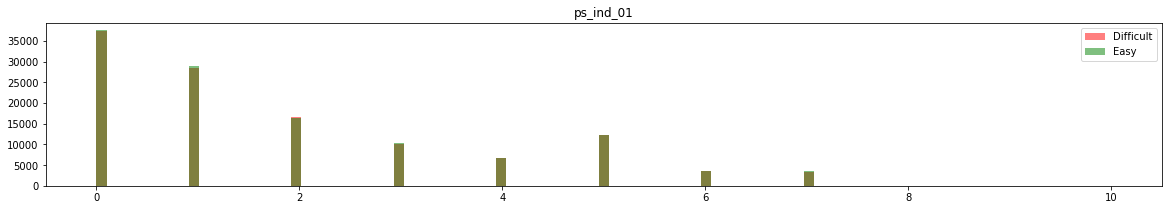

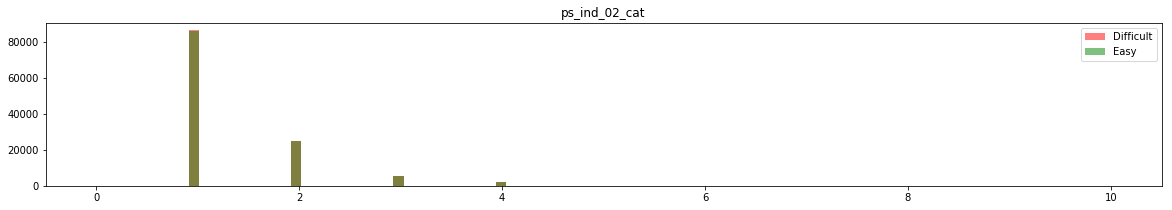

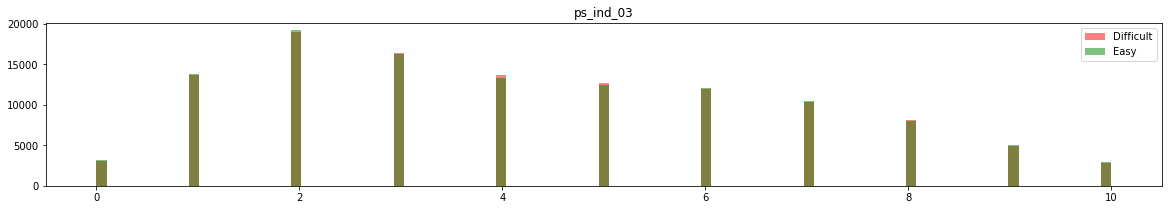

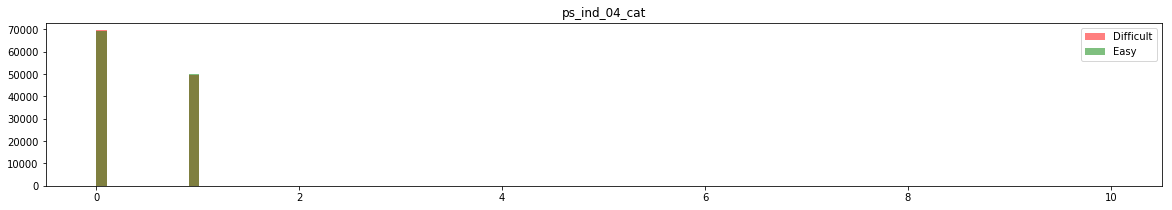

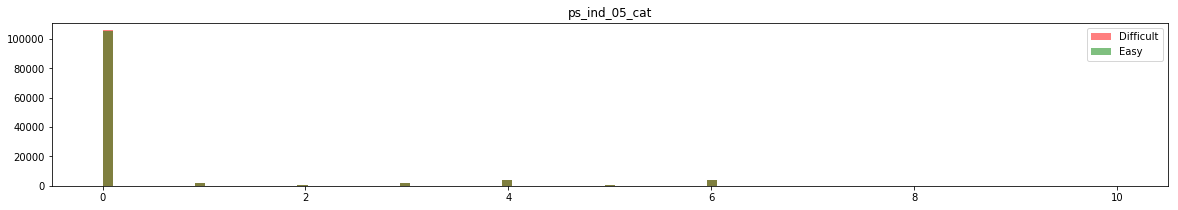

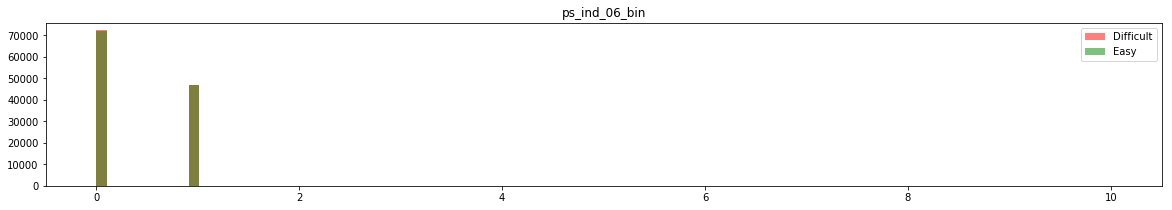

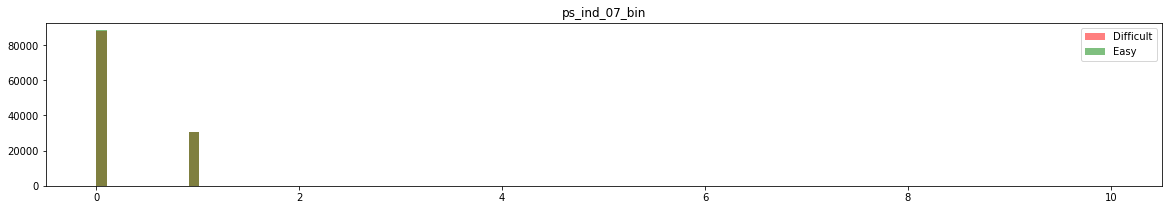

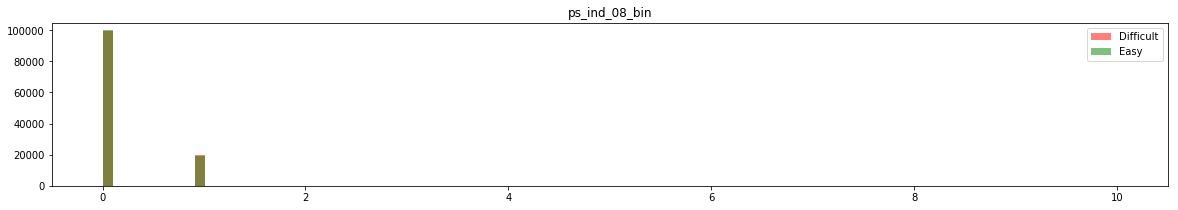

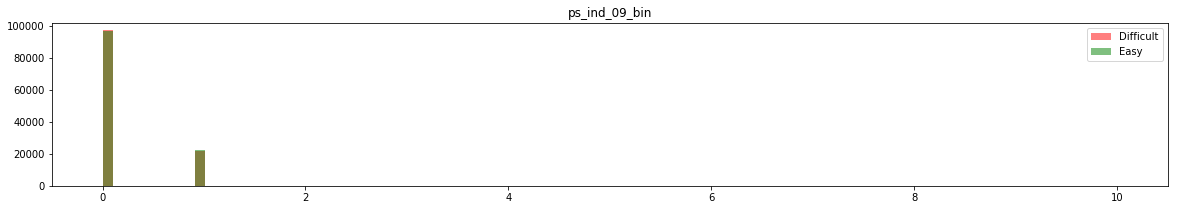

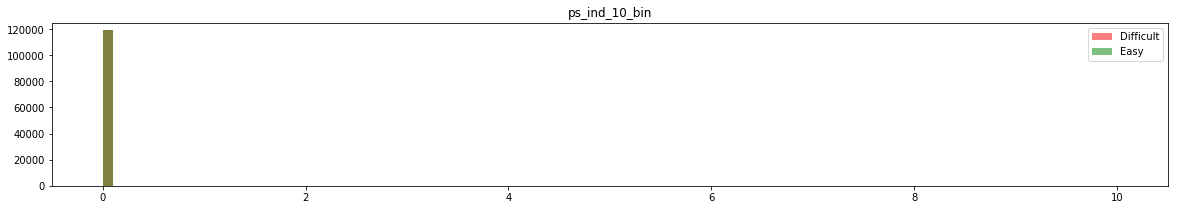

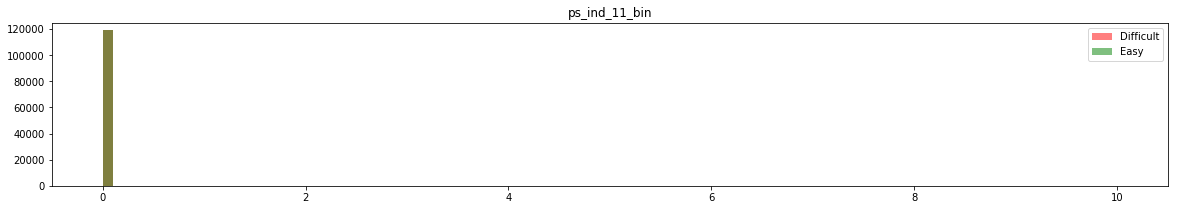

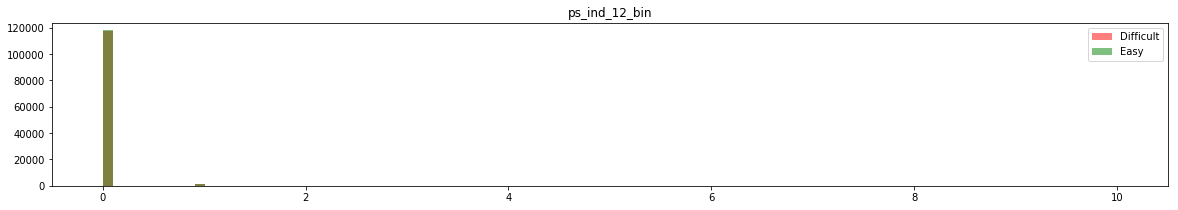

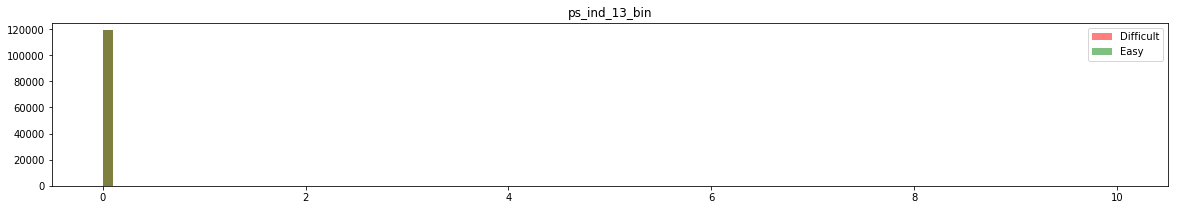

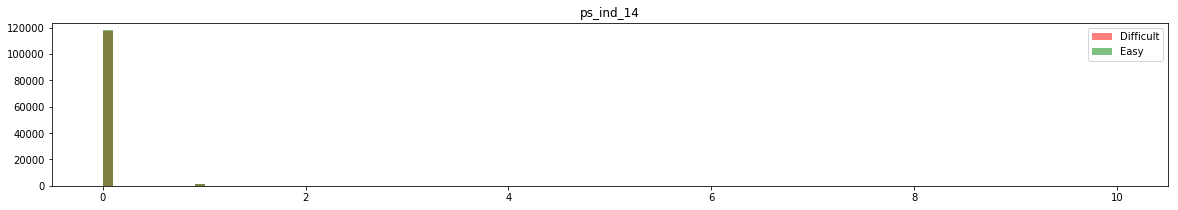

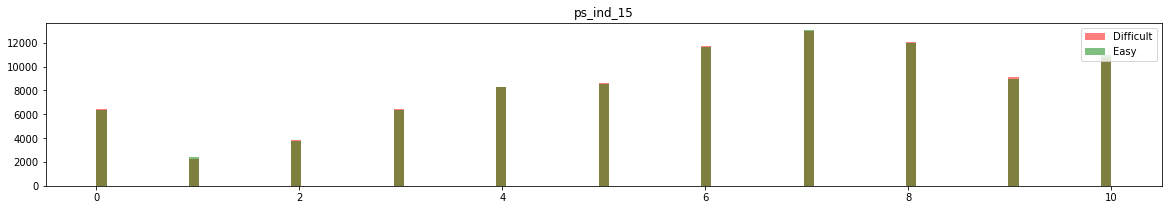

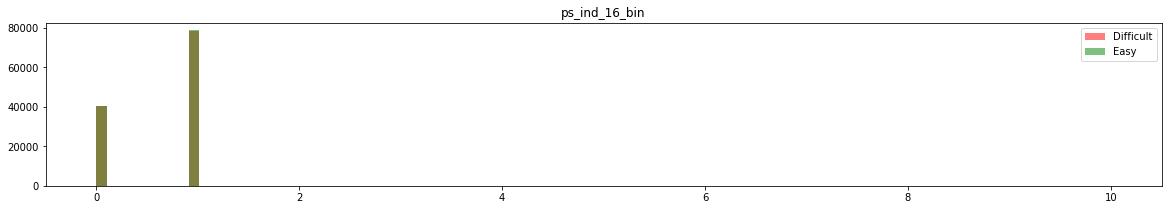

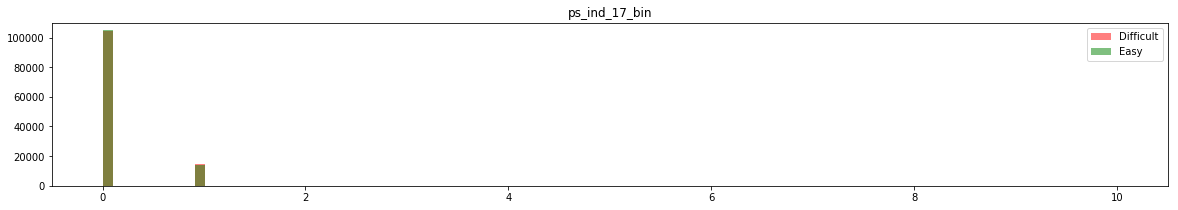

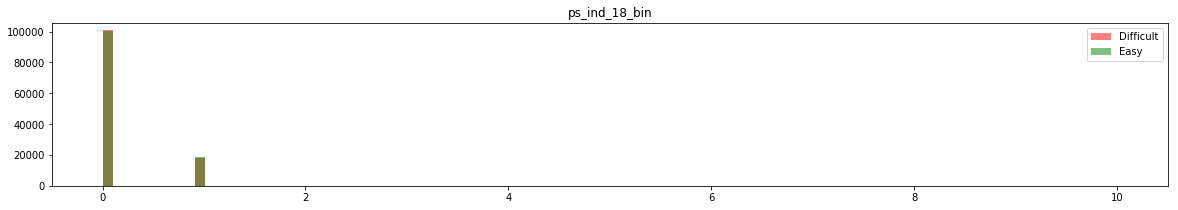

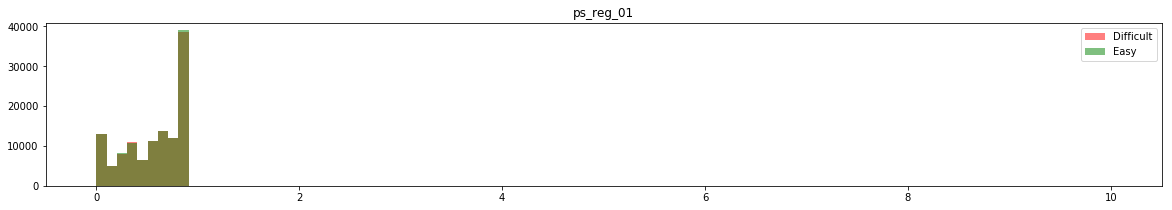

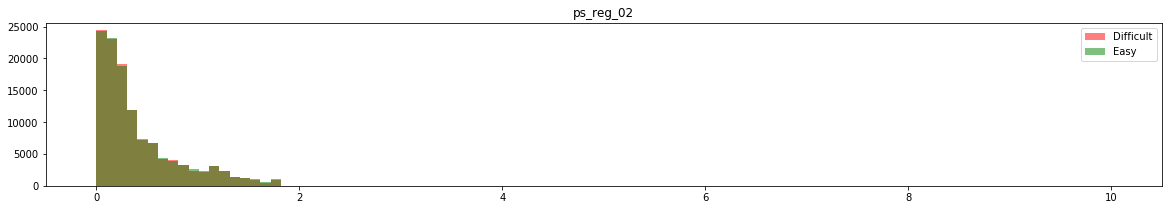

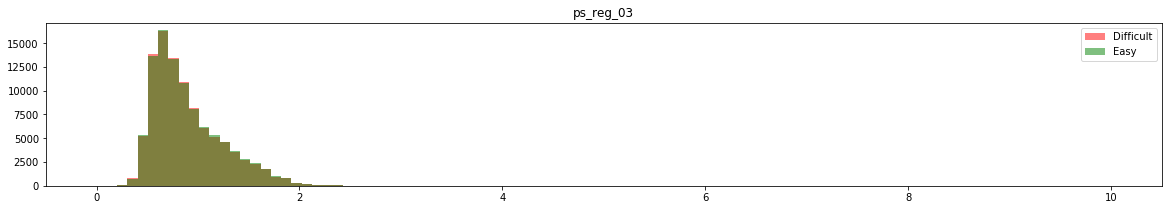

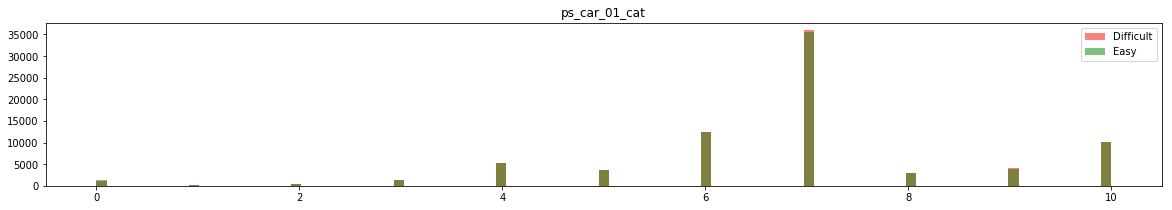

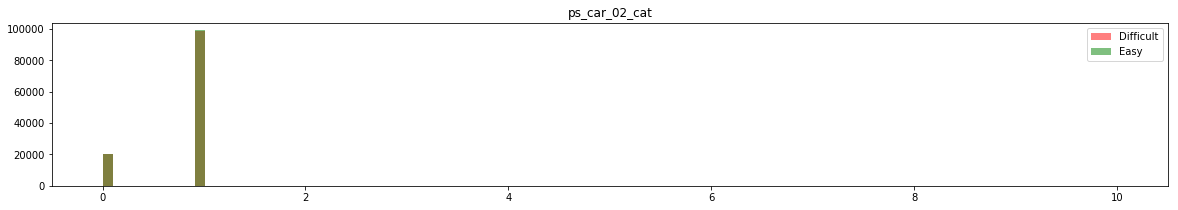

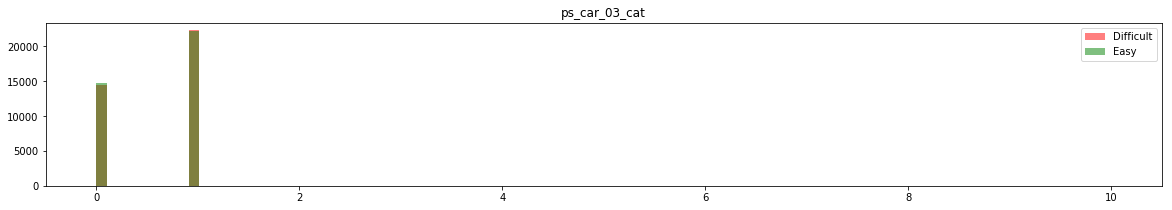

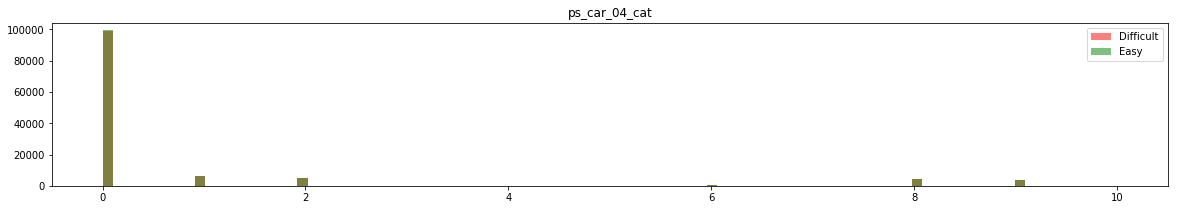

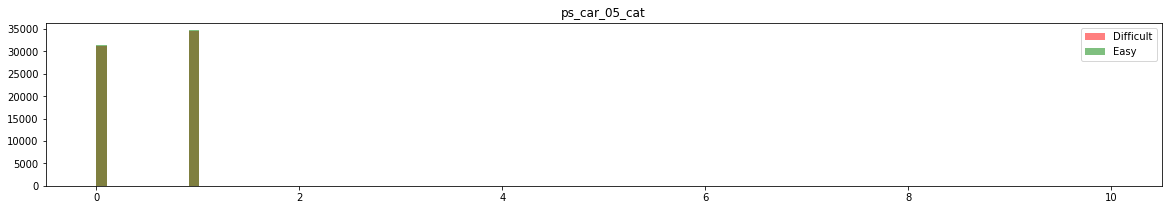

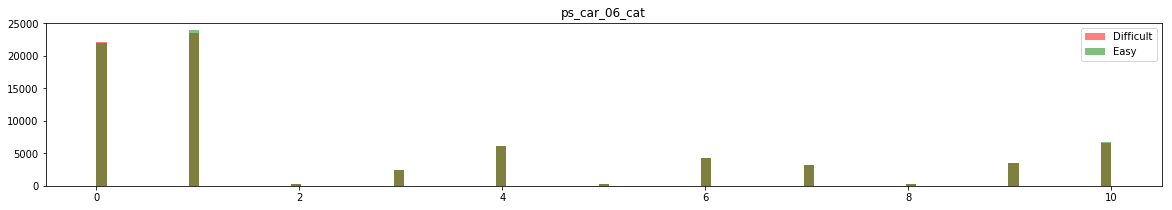

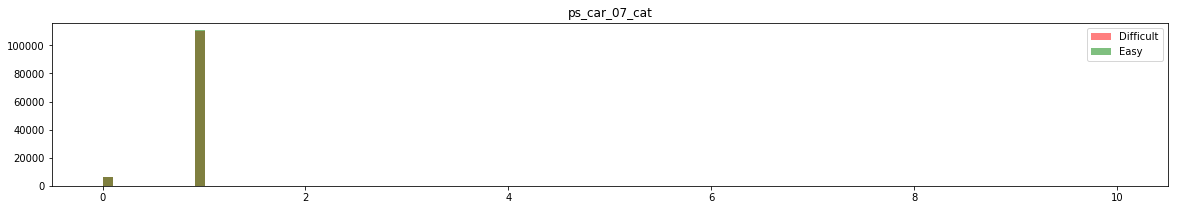

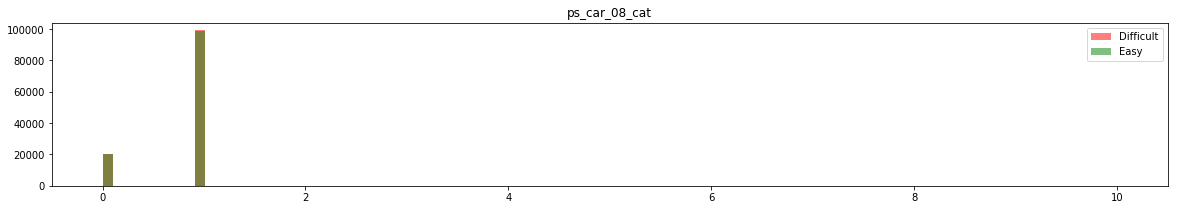

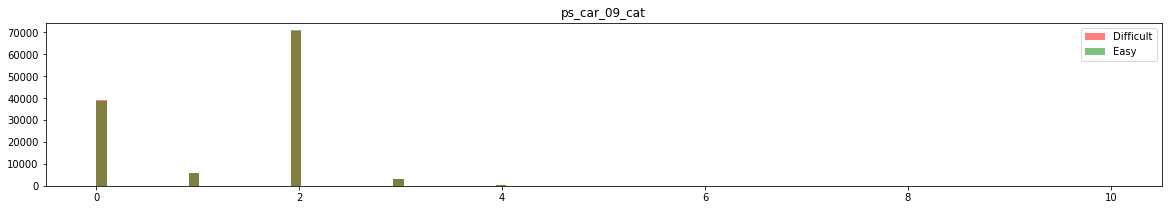

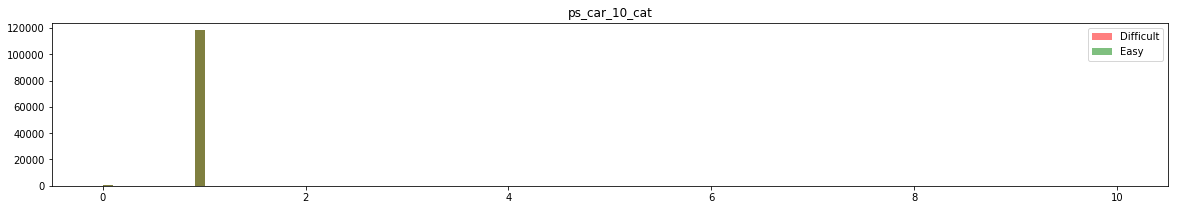

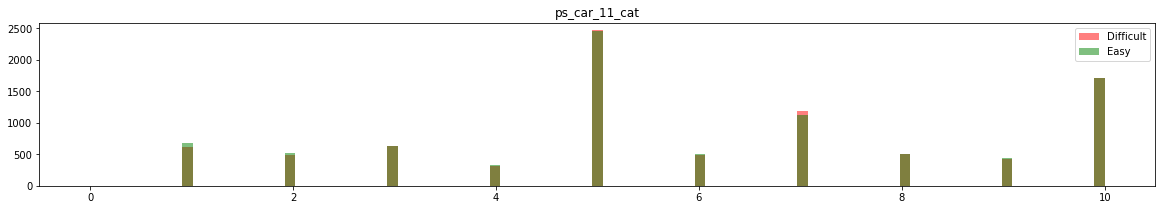

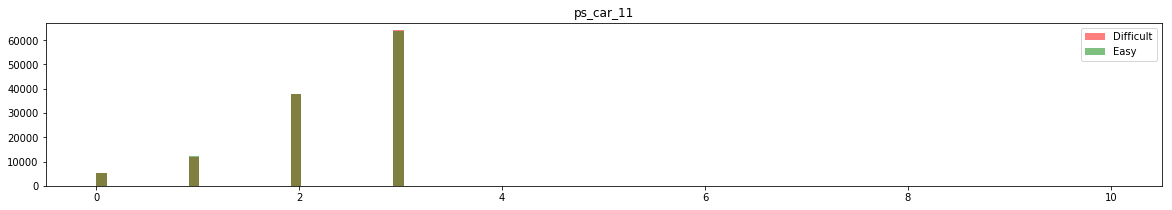

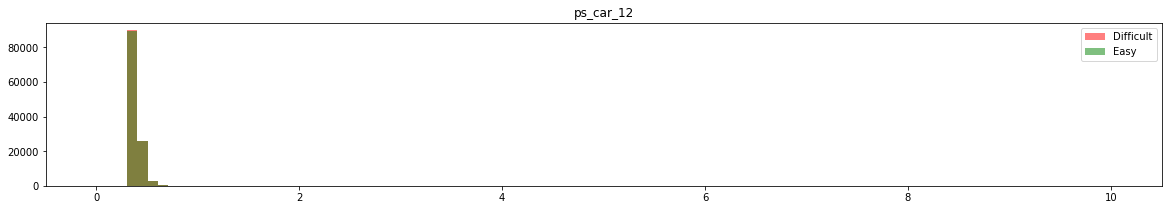

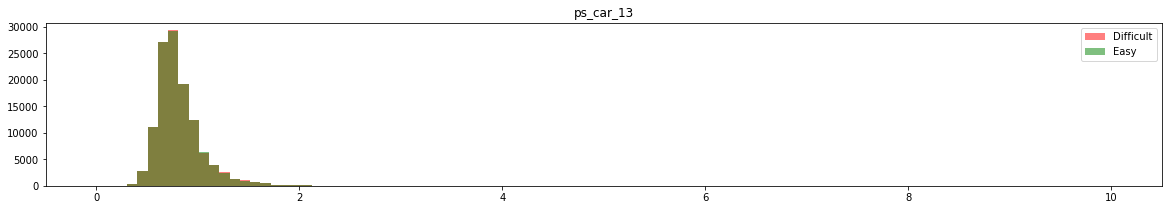

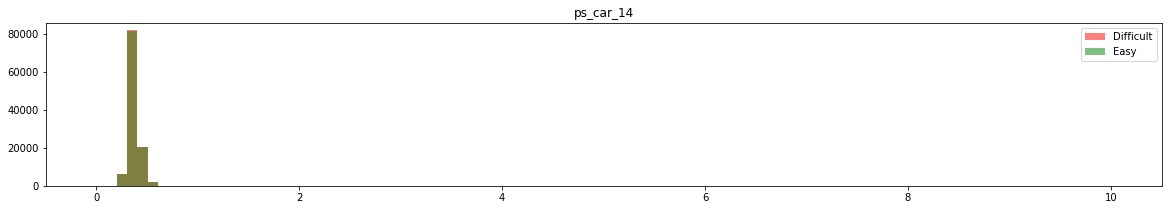

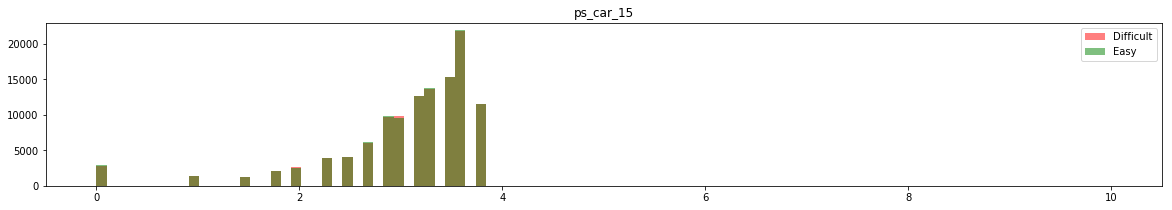

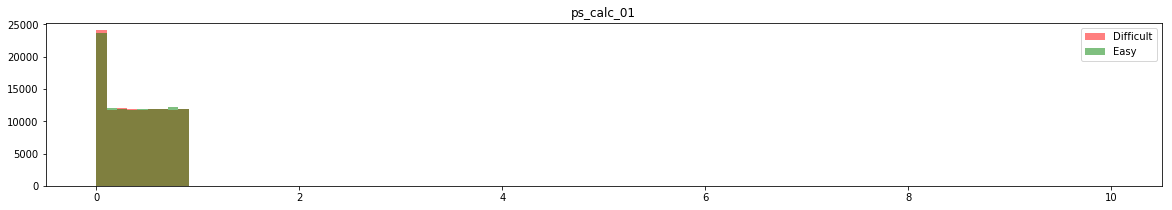

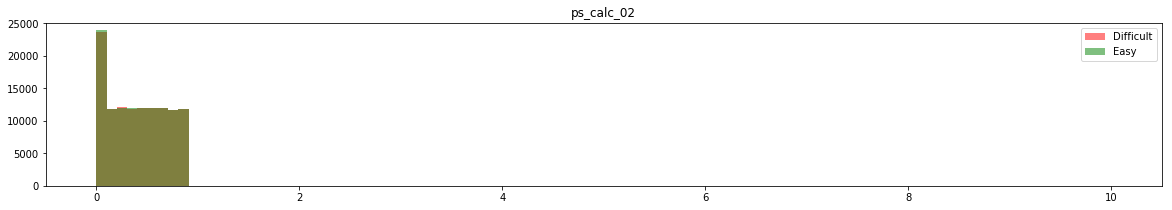

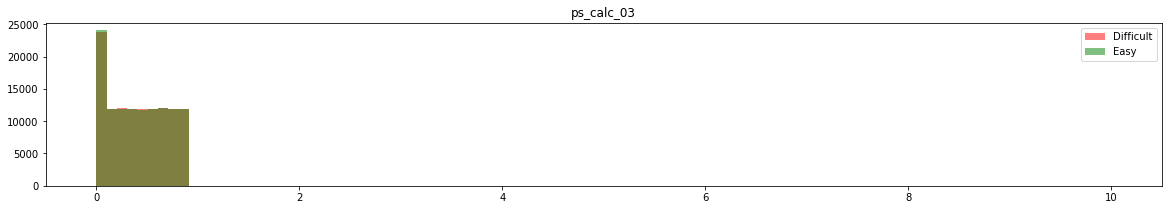

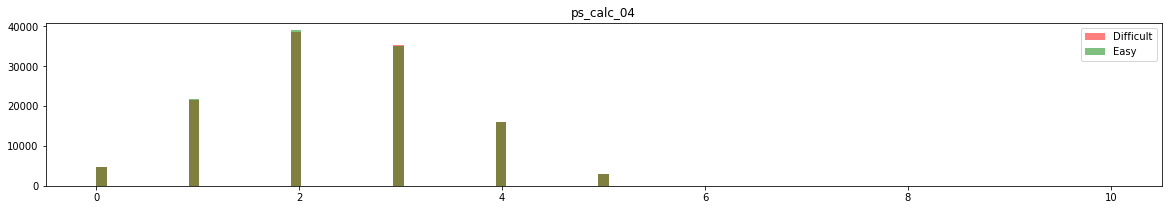

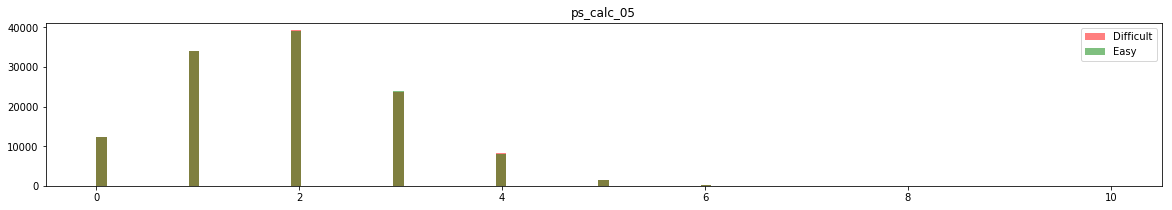

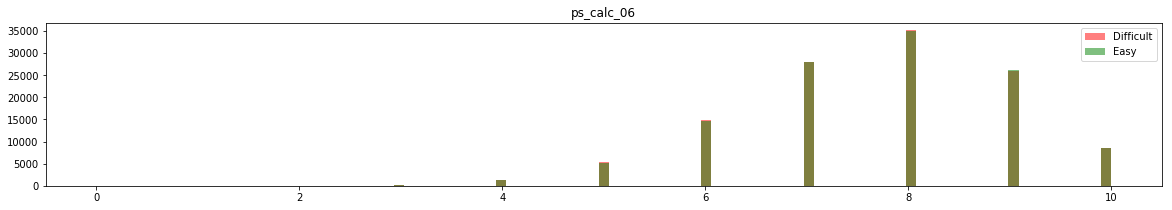

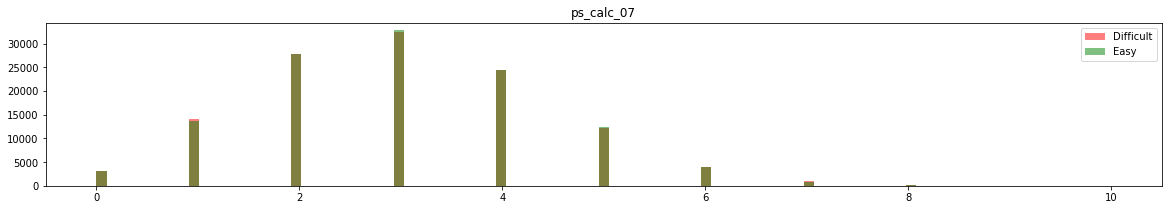

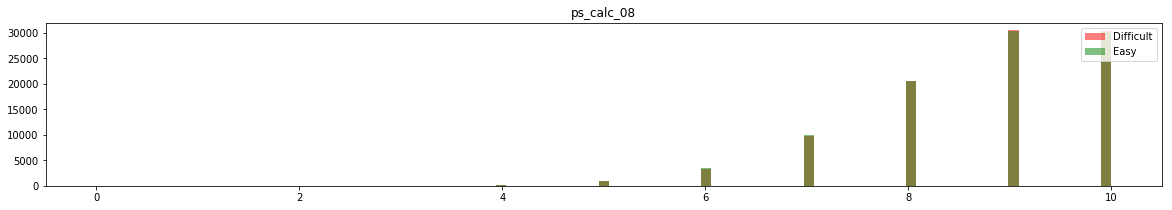

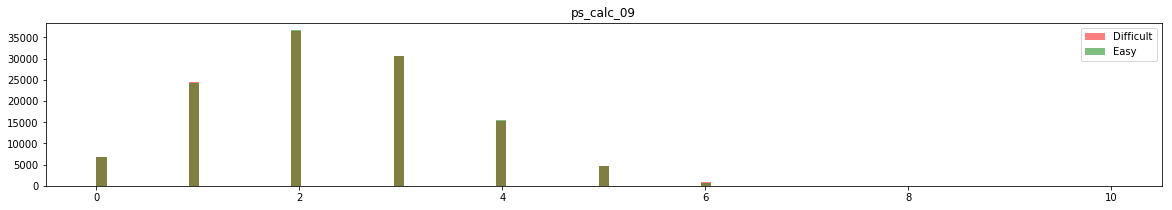

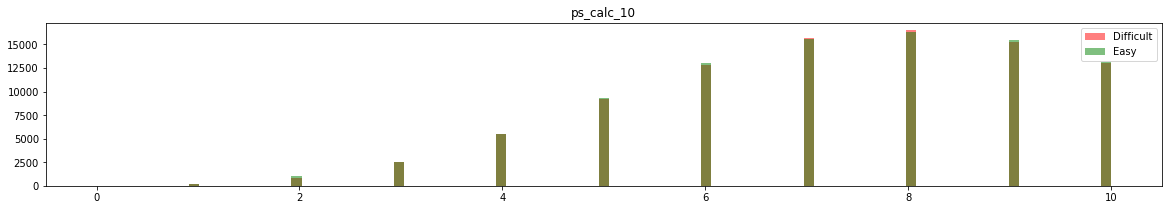

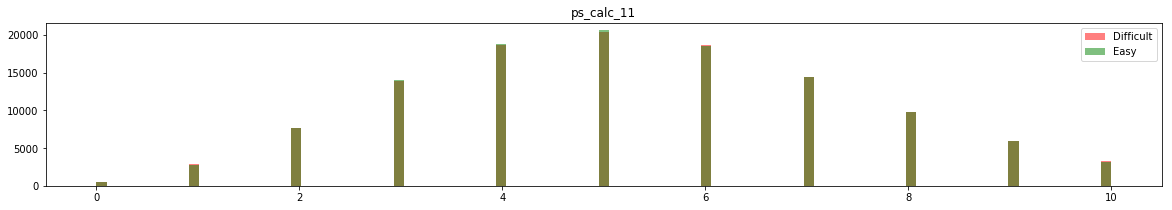

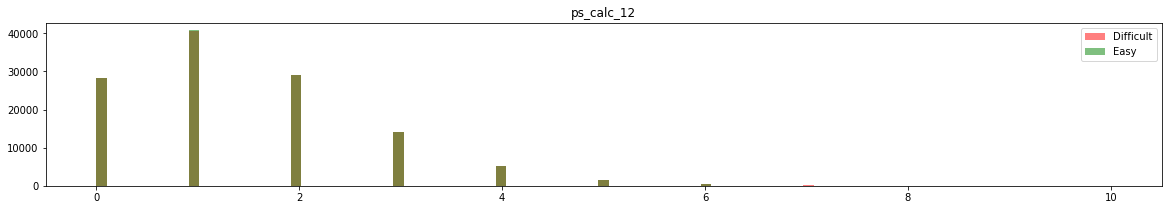

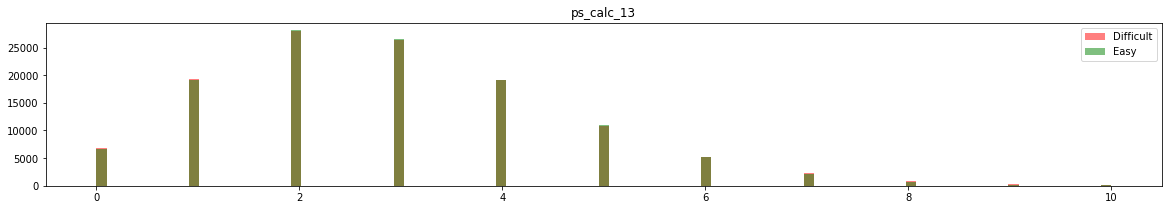

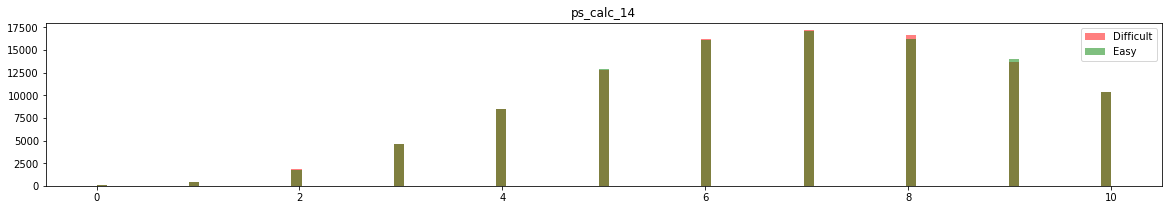

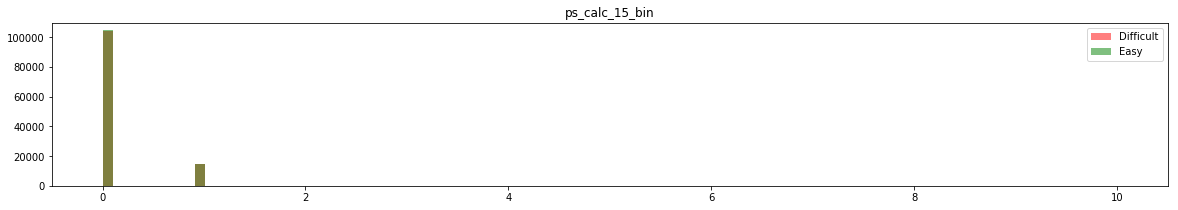

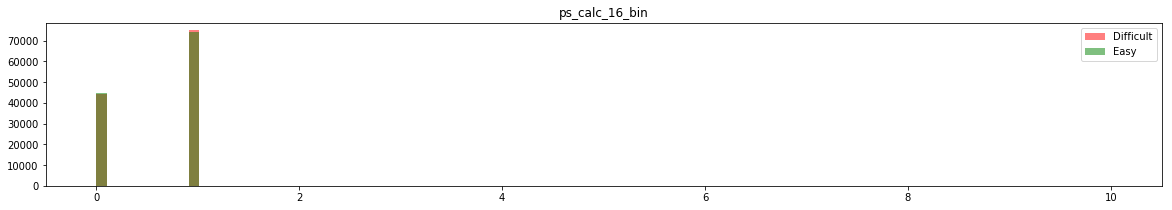

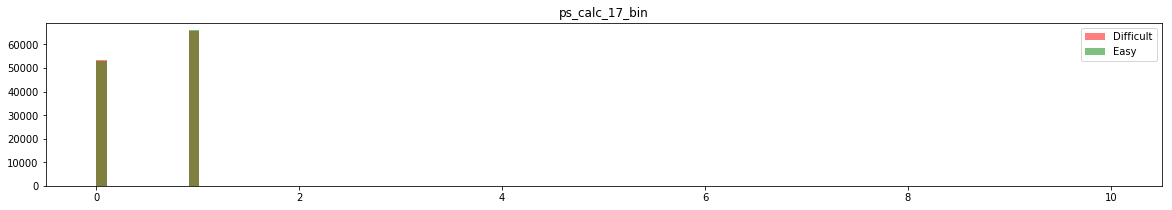

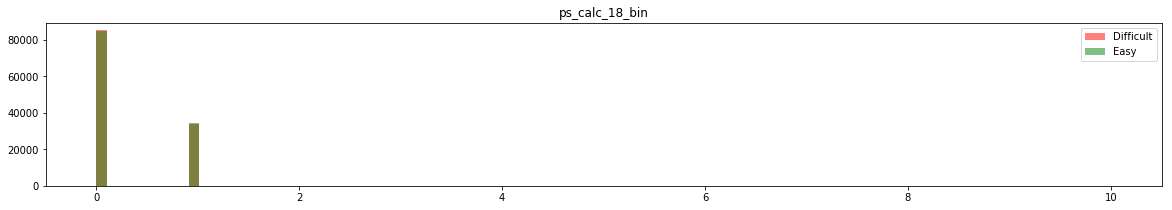

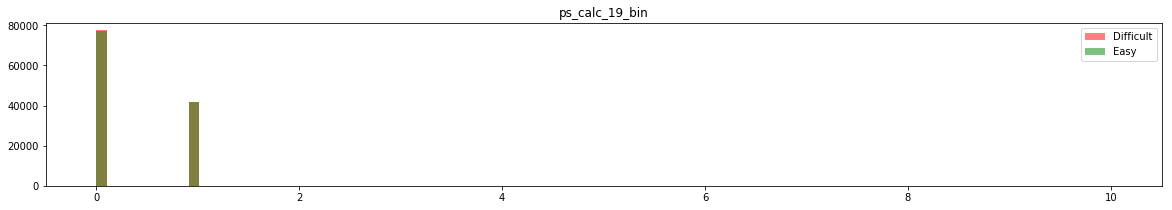

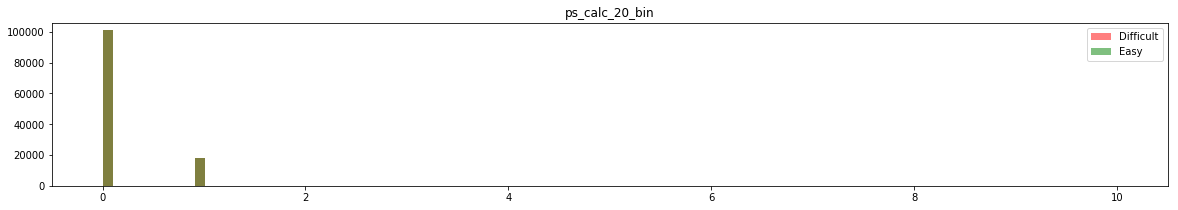

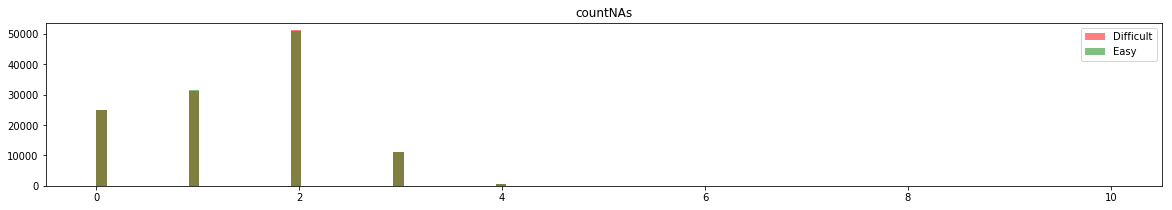

In [123]:
for col_name in train.columns:
    #bins = np.linspace(0, 10, 100)
    plt.figure(figsize=(20,3))
    ax = plt.subplot(11)
    ax.bar(x-0.2, y,width=0.2,color='b',align='center')
    ax.bar(x, z,width=0.2,color='g',align='center')
    plt.hist(X_difficult.loc[:, col_name], bins, color='red', alpha=0.5, label='Difficult')
    plt.hist(X_easy.loc[:, col_name], bins, color='green', alpha=0.5, label='Easy')
    #plt.boxplot([X_difficult.loc[:, col_name], X_easy.loc[:, col_name]], vert=0)
    plt.title(col_name)
    plt.legend(loc='upper right')
    plt.show()

#### Let's go for a t-test (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_rel.html#scipy.stats.ttest_rel)

In [106]:
for col in train.columns:
    if ttest_rel(X_easy.loc[:, col_name], X_difficult.loc[:, col_name])[1] <= 0.05:
        print(col)

Nothing :-(

#### Feature Extraction using Keras 

In [34]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.core import Dropout
import keras

In [35]:
model = Sequential()

model.add(Dense(units=150, input_dim=51))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(units=1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
model.fit(X, y, epochs=20, batch_size=100)
y_predict = model.predict_proba(X)
gini_normalized(y, y_predict)

592192/595212 [============================>.] - ETA: 0s

0.23641270256935454

In [41]:
from keras import backend as K

In [42]:
# with a Sequential model
get_features = K.function([model.layers[0].input],
                                  [model.layers[1].output])
layer_output = get_features([X])[0]

#### Identifying outliers

In [7]:
from sklearn.cluster import MiniBatchKMeans

In [16]:
clf = MiniBatchKMeans(verbose=1)

In [17]:
clf_fit = clf.fit(X)
#clf_fit.predict(X)

Init 1/3 with method: k-means++
Inertia for init 1/3: 35337.877894
Init 2/3 with method: k-means++
Inertia for init 2/3: 35538.386941
Init 3/3 with method: k-means++
Inertia for init 3/3: 34980.656558
Minibatch iteration 1/595300: mean batch inertia: 124.476256, ewa inertia: 124.476256 
Minibatch iteration 2/595300: mean batch inertia: 124.524927, ewa inertia: 124.476272 
Minibatch iteration 3/595300: mean batch inertia: 114.919712, ewa inertia: 124.473061 
Minibatch iteration 4/595300: mean batch inertia: 120.032300, ewa inertia: 124.471569 
Minibatch iteration 5/595300: mean batch inertia: 120.069004, ewa inertia: 124.470089 
Minibatch iteration 6/595300: mean batch inertia: 114.624967, ewa inertia: 124.466781 
Minibatch iteration 7/595300: mean batch inertia: 121.705839, ewa inertia: 124.465854 
Minibatch iteration 8/595300: mean batch inertia: 119.539139, ewa inertia: 124.464198 
Minibatch iteration 9/595300: mean batch inertia: 112.527229, ewa inertia: 124.460187 
Minibatch iterat

Minibatch iteration 474/595300: mean batch inertia: 113.183659, ewa inertia: 123.335240 
Minibatch iteration 475/595300: mean batch inertia: 118.989209, ewa inertia: 123.333780 
Minibatch iteration 476/595300: mean batch inertia: 119.788290, ewa inertia: 123.332588 
Minibatch iteration 477/595300: mean batch inertia: 119.994074, ewa inertia: 123.331467 
Minibatch iteration 478/595300: mean batch inertia: 117.751575, ewa inertia: 123.329592 
Minibatch iteration 479/595300: mean batch inertia: 109.907688, ewa inertia: 123.325082 
Minibatch iteration 480/595300: mean batch inertia: 113.292345, ewa inertia: 123.321711 
Minibatch iteration 481/595300: mean batch inertia: 115.636780, ewa inertia: 123.319128 
Minibatch iteration 482/595300: mean batch inertia: 117.921703, ewa inertia: 123.317315 
Minibatch iteration 483/595300: mean batch inertia: 124.812651, ewa inertia: 123.317817 
Minibatch iteration 484/595300: mean batch inertia: 112.710448, ewa inertia: 123.314253 
Minibatch iteration 4

Minibatch iteration 955/595300: mean batch inertia: 120.904165, ewa inertia: 122.375186 
Minibatch iteration 956/595300: mean batch inertia: 118.755395, ewa inertia: 122.373969 
Minibatch iteration 957/595300: mean batch inertia: 105.486934, ewa inertia: 122.368295 
Minibatch iteration 958/595300: mean batch inertia: 109.602492, ewa inertia: 122.364006 
Minibatch iteration 959/595300: mean batch inertia: 117.863705, ewa inertia: 122.362493 
Minibatch iteration 960/595300: mean batch inertia: 120.699112, ewa inertia: 122.361934 
Minibatch iteration 961/595300: mean batch inertia: 117.605769, ewa inertia: 122.360336 
Minibatch iteration 962/595300: mean batch inertia: 116.845537, ewa inertia: 122.358483 
Minibatch iteration 963/595300: mean batch inertia: 113.270518, ewa inertia: 122.355430 
Minibatch iteration 964/595300: mean batch inertia: 112.515164, ewa inertia: 122.352123 
Minibatch iteration 965/595300: mean batch inertia: 123.238973, ewa inertia: 122.352421 
Minibatch iteration 9

Minibatch iteration 1434/595300: mean batch inertia: 123.945224, ewa inertia: 121.500561 
Minibatch iteration 1435/595300: mean batch inertia: 106.982523, ewa inertia: 121.495683 
Minibatch iteration 1436/595300: mean batch inertia: 112.430335, ewa inertia: 121.492637 
Minibatch iteration 1437/595300: mean batch inertia: 112.914146, ewa inertia: 121.489755 
Minibatch iteration 1438/595300: mean batch inertia: 117.432413, ewa inertia: 121.488391 
Minibatch iteration 1439/595300: mean batch inertia: 117.659638, ewa inertia: 121.487105 
Minibatch iteration 1440/595300: mean batch inertia: 117.068119, ewa inertia: 121.485620 
Minibatch iteration 1441/595300: mean batch inertia: 113.300238, ewa inertia: 121.482870 
Minibatch iteration 1442/595300: mean batch inertia: 114.664859, ewa inertia: 121.480579 
Minibatch iteration 1443/595300: mean batch inertia: 119.775072, ewa inertia: 121.480006 
Minibatch iteration 1444/595300: mean batch inertia: 114.934625, ewa inertia: 121.477806 
Minibatch 

Minibatch iteration 1916/595300: mean batch inertia: 115.367683, ewa inertia: 120.811293 
Minibatch iteration 1917/595300: mean batch inertia: 113.881390, ewa inertia: 120.808965 
Minibatch iteration 1918/595300: mean batch inertia: 117.829863, ewa inertia: 120.807964 
Minibatch iteration 1919/595300: mean batch inertia: 115.697663, ewa inertia: 120.806246 
Minibatch iteration 1920/595300: mean batch inertia: 108.793698, ewa inertia: 120.802210 
Minibatch iteration 1921/595300: mean batch inertia: 112.993428, ewa inertia: 120.799586 
Minibatch iteration 1922/595300: mean batch inertia: 118.483178, ewa inertia: 120.798808 
Minibatch iteration 1923/595300: mean batch inertia: 115.725834, ewa inertia: 120.797103 
Minibatch iteration 1924/595300: mean batch inertia: 121.906582, ewa inertia: 120.797476 
Minibatch iteration 1925/595300: mean batch inertia: 110.224310, ewa inertia: 120.793923 
Minibatch iteration 1926/595300: mean batch inertia: 122.583637, ewa inertia: 120.794525 
Minibatch 

Minibatch iteration 2399/595300: mean batch inertia: 114.928202, ewa inertia: 120.191946 
Minibatch iteration 2400/595300: mean batch inertia: 113.547992, ewa inertia: 120.189713 
Minibatch iteration 2401/595300: mean batch inertia: 119.295231, ewa inertia: 120.189413 
Minibatch iteration 2402/595300: mean batch inertia: 124.918333, ewa inertia: 120.191002 
Minibatch iteration 2403/595300: mean batch inertia: 111.074758, ewa inertia: 120.187938 
Minibatch iteration 2404/595300: mean batch inertia: 114.894911, ewa inertia: 120.186160 
Minibatch iteration 2405/595300: mean batch inertia: 113.339217, ewa inertia: 120.183859 
Minibatch iteration 2406/595300: mean batch inertia: 116.247205, ewa inertia: 120.182536 
Minibatch iteration 2407/595300: mean batch inertia: 120.245621, ewa inertia: 120.182558 
Minibatch iteration 2408/595300: mean batch inertia: 115.869809, ewa inertia: 120.181108 
Minibatch iteration 2409/595300: mean batch inertia: 123.788060, ewa inertia: 120.182320 
Minibatch 

In [18]:
outliers = clf_fit.predict(X)

Computing label assignment and total inertia


In [27]:
for clus in set(list(outliers)):
    print(np.where(outliers==clus)[0].shape)
    print(y[np.where(outliers==clus)[0]].sum()/np.where(outliers==clus)[0].shape[0])

(36410,)
0.037544630596
(58961,)
0.0308000203524
(78632,)
0.0365627225557
(147963,)
0.0400032440543
(66789,)
0.0344517809819
(55262,)
0.0375122145416
(88462,)
0.0336189550315
(62733,)
0.0377632187206


In [10]:
import gc
gc.collect()

0

In [14]:
odd_ones = np.where(outliers==1)[0]

In [89]:
X = np.delete(X, odd_ones, axis=0)
y = np.delete(y, odd_ones, axis=0)

In [27]:
xgb_out = pd.read_csv('./submit/v_compare_rank_vs_prob_avg__prob_avg.csv.gz')

In [48]:
preds = np.zeros((X.shape[0]))
preds[odd_ones] = 1

In [50]:
gini_normalized(y, preds)

0.066157926008746773

In [37]:
xgb_out.iloc[odd_ones,:]

,id,target
8,10,0.813932
12,15,0.819686
21,31,0.829288
26,39,0.972498
37,54,0.922139
40,57,0.982983
58,88,0.943671
70,114,0.689162
72,118,0.980823
91,152,0.877198
